# Quick start--Example codes to run MAX-CUT QAOA

This is a notebook designed to provide a quick start for people to run the test experiments faster (without running on a very large system)
The code layouts are the same as the python codes (except having no file saving and running on a much smaller graph) that are actually running the experiments reported in the manuscript:
"Error-mitigated Quantum Approximate Optimization via Learning-based Adaptive Optimization" by Lixue Cheng, Yu-Qin Chen, Shi-Xin Zhang, and Shengyu Zhang.


In [9]:
import tensorcircuit as tc
import tensorflow as tf
import cotengra as ctg
import optax
import networkx as nx
import time 
import numpy as np
import torch
import os 
K = tc.set_backend("tensorflow")

In [10]:
# cotengra package to speedup the calculation. This block is not required if your experiments are small
opt_ctg = ctg.ReusableHyperOptimizer(
    methods=["greedy", "kahypar"],
    parallel="ray",
    minimize="combo",
    max_time=1200,
    max_repeats=128,
    progbar=True,
)

tc.set_contractor("custom", optimizer=opt_ctg, preprocessing=True)

functools.partial(<function custom at 0x7f86cbb02a60>, optimizer=<cotengra.hyper.ReusableHyperOptimizer object at 0x7f86a0ff4220>, memory_limit=None, debug_level=0, preprocessing=True)

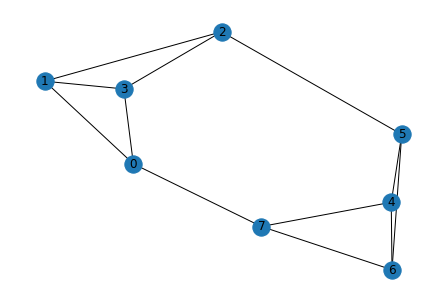

In [11]:
# Generate a graph
def dict2graph(d):
    g = nx.to_networkx_graph(d)
    for e in g.edges:
        if not g[e[0]][e[1]].get("weight"):
            g[e[0]][e[1]]["weight"] = 1.0
    nx.draw(g, with_labels=True)
    return g

# a graph instance
example_graph_dict = {
    0: {1: {"weight": 0.9}, 7: {"weight": 0.4}, 3: {"weight": 0.38}},
    1: {0: {"weight": 0.44}, 2: {"weight": 0.67}, 3: {"weight": 0.62}},
    2: {1: {"weight": 0.21}, 3: {"weight": 0.87}, 5: {"weight": 0.72}},
    4: {7: {"weight": 0.34}, 6: {"weight": 0.53}, 5: {"weight": 0.45}},
    7: {4: {"weight": 0.45}, 6: {"weight": 0.63}, 0: {"weight": 0.59}},
    3: {1: {"weight": 0.12}, 2: {"weight": 0.21}, 0: {"weight": 0.68}},
    6: {7: {"weight": 0.34}, 4: {"weight": 0.33}, 5: {"weight": 0.96}},
    5: {6: {"weight": 0.18}, 4: {"weight": 0.79}, 2: {"weight": 0.17}},
}

example_graph = dict2graph(example_graph_dict)

In [12]:
# Define QAOA ansatz without shot noises
def QAOAansatz(params, g=example_graph):
    n = len(g.nodes)  # the number of nodes
    c = tc.Circuit(n)
    for i in range(n):
        c.H(i)
    # PQC
    for j in range(nlayers):
        # U_j
        for e in g.edges:
            c.exp1(e[0], e[1], unitary=tc.gates._zz_matrix,
                theta=g[e[0]][e[1]].get("weight", 1.0) * params[2 * j],)
        # V_j
        for i in range(n):
            c.rx(i, theta=params[2 * j + 1])

    # calculate the loss function
    loss = 0.0
    for e in g.edges:
        loss += g[e[0]][e[1]].get("weight") * c.expectation_ps(z=[e[0], e[1]])
    return K.real(loss)


## Optimize using Adam

In [13]:
# use vvag to get the losses and gradients with different random circuit instances
nlayers = 4  # the number of layers
QAOA_vvag = K.jit(tc.backend.vvag(QAOAansatz, argnums=0, vectorized_argnums=0))
params = np.random.uniform(low= 0, high= 1, size=[1, 2 * nlayers]) #initialization # initial parameters
initial_X = params

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=100,
    decay_rate=0.95,
    staircase=False)
opt = K.optimizer(tf.keras.optimizers.Adam(learning_rate=lr_schedule))

for i in range(100):
    loss, grads = QAOA_vvag(params, example_graph)
    print(K.numpy(loss))
    params = opt.update(grads, params)  # gradient descent


KeyboardInterrupt



## TuRBO optimizer (maximize the -loss)


In [ ]:
QAOA_vvag_nograd = K.jit(QAOAansatz)

def eval_objective(x, example_graph):
    """This is a helper function we use to unnormalize and evalaute a point"""
    a = tf.convert_to_tensor(np.array(x).ravel())
    return -QAOA_vvag_nograd(a, example_graph).numpy()

In [14]:
import odbo
# TuRBO settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
batch_size, failure_tolerance = 1, 10
acqfn='ucb'
tr_length= [1.6]

## Note TuRBO is working on only [0,1] parameter range, so we need to convert the space 
## First point by BO is actually just a random selection, to have a better search, we pick the most distant point
X_new = []
for i in range(initial_X.shape[1]):
    if initial_X[0,i] <=0.5:
        X_new.append(initial_X[0,i]+0.5)
    else:
        X_new.append(initial_X[0,i]-0.5)
X_new = np.array(X_new).reshape(1, 2 * nlayers) #X_new = np.random.uniform(low= 0, high= 1, size=[1, 2 * nlayers]) if you want a random pick
paras = np.vstack([initial_X, X_new])
X_turbo = torch.tensor(paras/2/np.pi+0.5) # transform space from [-pi,pi] to [0,1]
Y_turbo = torch.tensor([eval_objective(x*2*np.pi-np.pi, example_graph) for x in X_turbo], dtype=dtype, device=device).unsqueeze(-1)
## check the transformation is correct
assert np.max(np.abs(Y_turbo.numpy().ravel()-[eval_objective(x, example_graph) for x in paras]))<=1e-6
# prepare TR state
state = odbo.turbo.TurboState(dim=X_turbo.shape[1], batch_size=batch_size, length=tr_length, n_trust_regions=len(tr_length), failure_tolerance = failure_tolerance)
state.best_value = Y_turbo.max()


log2[SIZE]: 8.00 log10[FLOPs]: 4.86: 100%|███████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 69.11it/s]


In [15]:
# TuRBO Optimizer
for i in range(100): # run 100 iter optimizations
    X_next, acq_value, ids = odbo.run_exp.turbo_design(state=state,X=X_turbo,Y=Y_turbo, n_trust_regions=len(tr_length), batch_size=batch_size, acqfn=acqfn, normalize=False, verbose=False)
    X_next = torch.reshape(X_next, [len(tr_length)*batch_size, 2*nlayers])
    X_next_paras = X_next*2*np.pi-np.pi
    paras = np.vstack([paras, np.array(X_next_paras)])
    Y_next = torch.tensor([eval_objective(x,example_graph) for x in X_next_paras], dtype=dtype, device=device)
    # Update state
    state = odbo.turbo.update_state(state=state, Y_next=torch.reshape(Y_next, [len(tr_length), batch_size, 1]))
    X_turbo = torch.cat((X_turbo, X_next), dim=0)
    Y_turbo = torch.cat((Y_turbo, Y_next.unsqueeze(-1)), dim=0)
    print(f"{i+1}) New loss: {-Y_next.item(): .4e} Best loss: {-state.best_value:.4e}, TR length: {state.length}")


1) New loss: -1.1099e-01 Best loss: -1.1099e-01, TR length: [1.6]
2) New loss:  2.9827e-01 Best loss: -1.1099e-01, TR length: [1.6]
3) New loss: -2.0681e-01 Best loss: -2.0681e-01, TR length: [1.6]
4) New loss: -2.7050e-01 Best loss: -2.7050e-01, TR length: [1.6]
5) New loss: -1.5481e-01 Best loss: -2.7050e-01, TR length: [1.6]
6) New loss:  2.1909e-01 Best loss: -2.7050e-01, TR length: [1.6]
7) New loss: -2.3819e-01 Best loss: -2.7050e-01, TR length: [1.6]
8) New loss: -1.3949e-01 Best loss: -2.7050e-01, TR length: [1.6]
9) New loss: -6.5859e-02 Best loss: -2.7050e-01, TR length: [1.6]
10) New loss: -1.2096e-01 Best loss: -2.7050e-01, TR length: [1.6]
11) New loss: -2.6421e-01 Best loss: -2.7050e-01, TR length: [1.6]
12) New loss: -1.9172e-01 Best loss: -2.7050e-01, TR length: [1.6]
13) New loss: -3.3921e-01 Best loss: -3.3921e-01, TR length: [1.6]
14) New loss: -2.1414e-01 Best loss: -3.3921e-01, TR length: [1.6]
15) New loss: -6.7441e-02 Best loss: -3.3921e-01, TR length: [1.6]
16) 


KeyboardInterrupt



## DARBO optimizer

In [16]:
import odbo
# DARBO settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
batch_size, failure_tolerance = 1, 10
acqfn='ucb'
tr_length= [1.6]
switch, switch_counter = 'small', 0

## Note TR is working on only [0,1] parameter range, so we need to convert the true parameter spaces
## First point by BO is actually just a random selection 
X_new = []
for i in range(initial_X.shape[1]):
    if initial_X[0,i] <=0.5:
        X_new.append(initial_X[0,i]+0.5)
    else:
        X_new.append(initial_X[0,i]-0.5)
X_new = np.array(X_new).reshape(1, 2 * nlayers) #X_new = np.random.uniform(low= 0, high= 1, size=[1, 2 * nlayers]) if you want a random pick

paras = np.vstack([initial_X, X_new])
if switch == 'large':
    X_turbo = torch.tensor(paras/2/np.pi+0.5) # transform space from [-pi,pi] to [0,1]
    Y_turbo = torch.tensor([eval_objective(x*2*np.pi-np.pi, example_graph) for x in X_turbo], dtype=dtype, device=device).unsqueeze(-1)
if switch == 'small':
    X_turbo = torch.tensor(paras/np.pi+0.5) # transform space from [-pi/2,pi/2] to [0,1]
    Y_turbo = torch.tensor([eval_objective(x*np.pi-np.pi/2, example_graph) for x in X_turbo], dtype=dtype, device=device).unsqueeze(-1)

## check the transformation is correct
assert np.max(np.abs(Y_turbo.numpy().ravel()-[eval_objective(x, example_graph) for x in paras]))<=1e-6
# prepare TR state
state = odbo.turbo.TurboState(dim=X_turbo.shape[1], batch_size=batch_size, length=tr_length, n_trust_regions=len(tr_length), failure_tolerance = failure_tolerance)
state.best_value = Y_turbo.max()


In [17]:
# DARBO Optimizer (we only show the 2 searching region case)
for i in range(100):
    # check if we need to switch the searching parameter range.
    if switch_counter >=4:
        if switch == 'small':
            switch = 'large'
            X_turbo = X_turbo/2
        else:
            switch = 'small'
            X_turbo = X_turbo*2
        switch_counter = 0
    
    X_next, acq_value, ids = odbo.run_exp.turbo_design(state=state,X=X_turbo,Y=Y_turbo, n_trust_regions=len(tr_length), batch_size=batch_size, acqfn=acqfn, normalize=False, verbose=False)
    X_next = torch.reshape(X_next, [len(tr_length)*batch_size, 2*nlayers])
    if switch == 'small':
        X_next_paras = X_next*np.pi-np.pi/2      
    else:
        X_next_paras = X_next*2*np.pi-np.pi
    paras = np.vstack([paras, np.array(X_next_paras)])
    Y_next = torch.tensor([eval_objective(x,example_graph) for x in X_next_paras], dtype=dtype, device=device)
    if np.max(np.array(Y_next)) < np.max(np.array(Y_turbo)):
        switch_counter = switch_counter + 1
        
    # Update state
    state = odbo.turbo.update_state(state=state, Y_next=torch.reshape(Y_next, [len(tr_length), batch_size, 1]))
    X_turbo = torch.cat((X_turbo, X_next), dim=0)
    Y_turbo = torch.cat((Y_turbo, Y_next.unsqueeze(-1)), dim=0)
    # Check if this search is a failure or not. Fail then add a switch counter
    print(f"{i+1}) New loss: {-Y_next.item(): .4e} Best loss: {-state.best_value:.4e}, TR length: {state.length}")


1) New loss:  1.6562e+00 Best loss: 1.2864e+00, TR length: [1.6]
2) New loss:  1.2077e+00 Best loss: 1.2077e+00, TR length: [1.6]
3) New loss:  1.1775e+00 Best loss: 1.1775e+00, TR length: [1.6]
4) New loss:  1.4812e+00 Best loss: 1.1775e+00, TR length: [1.6]
5) New loss:  3.0955e-01 Best loss: 3.0955e-01, TR length: [1.6]
6) New loss: -4.7282e-01 Best loss: -4.7282e-01, TR length: [1.6]
7) New loss: -6.0734e-01 Best loss: -6.0734e-01, TR length: [3.2]
8) New loss: -7.8780e-01 Best loss: -7.8780e-01, TR length: [3.2]
9) New loss: -5.0299e-01 Best loss: -7.8780e-01, TR length: [3.2]
10) New loss: -4.7907e-01 Best loss: -7.8780e-01, TR length: [3.2]
11) New loss: -8.8536e-01 Best loss: -8.8536e-01, TR length: [3.2]
12) New loss: -5.3385e-01 Best loss: -8.8536e-01, TR length: [3.2]
13) New loss: -1.0542e+00 Best loss: -1.0542e+00, TR length: [3.2]
14) New loss: -8.8347e-01 Best loss: -1.0542e+00, TR length: [3.2]
15) New loss: -1.7151e+00 Best loss: -1.7151e+00, TR length: [3.2]
16) New l